In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
def span_vec_objective(z, A, W, X): # a function of vector z, A, W and X are parameters
  num_rows, num_cols = A.shape
  obj = 0
  z = z/np.linalg.norm(z)
  for j in range(num_cols):
    gradient_fj_xj = []
    for row_index in range(num_rows):
      gradient_fj_xj.append(-2*W[row_index,j]*(A[row_index,j]-X[row_index,j]))
    obj += (gradient_fj_xj@z)**2
  return obj

def col_vec_approx_obj(v, A, W, j):
  num_rows, _ = A.shape
  obj = 0
  for row_index in range(num_rows):
    obj += W[row_index,j]*(A[row_index,j]-v[row_index])**2
  return obj

In [3]:
def wlra_iter(A, W, k):
  num_rows, num_cols = A.shape
  Z = []
  X = []
  # for _ in range(num_cols):
  #   X.append(np.zeros(num_rows))
  X = np.zeros(A.shape)
  cost_lst = []
  for t in range(k):
    obj_func = lambda z: -1*span_vec_objective(z, A, W, X) # function to minimize
    # constraints = [{'type': 'eq', 'fun': lambda z: np.sqrt(z.T@z)-1}]
    z0 = np.random.rand(num_cols) # initial guess
    z0 = z0 / np.linalg.norm(z0)
    # z = minimize(obj_func, z0, constraints=constraints).x
    z = minimize(obj_func, z0).x
    Z.append(z)
    
    for j in range(num_cols):
      # obj_func = lambda eta: col_vec_approx_obj(X[j]+eta*z, A, W, j)
      obj_func = lambda eta: col_vec_approx_obj(X[:,j]+eta*z, A, W, j)
      eta0 = 1 # initial guess
      eta = minimize(obj_func, eta0).x
      # x_prime = X[j]+eta*z
      x_prime = X[:,j]+eta*z

      obj_func = lambda eta: col_vec_approx_obj(eta*x_prime, A, W, j)
      eta0 = 1 # initial guess
      eta = minimize(obj_func, eta0).x
      X[:,j] = eta*x_prime
      # X[j] = eta*x_prime
    cost = np.sum(W*(X-A)**2)
    cost_lst.append(cost)
    print('iter:', t, 'cost:', cost)
  return X, cost_lst
  # return np.array(X).T

In [4]:
# Generate matrix datasets

dim = 100 # parameter

M1,_ = np.linalg.qr(np.random.randn(dim,5))
M2,_ = np.linalg.qr(np.random.randn(dim,5))
S = np.diag(np.array([1,0.9,0.9**2,0.9**3,0.9**4]))
M = M1@S@M2.T

sigma = 0.005
noise = np.random.normal(0, sigma, (dim,dim))
A = M + noise

W1 = np.random.uniform(0,1,(dim,dim))

#generate W2
# largest x entries of A
num_of_largest = 2000 # parameter
largest = np.argpartition(A.ravel(), -num_of_largest)[-num_of_largest:]
row_indices, col_indices = np.unravel_index(largest, A.shape)
W2 = np.ones((dim,dim))
for i in range(num_of_largest):
  W2[row_indices[i],col_indices[i]] = 0

W3 = np.random.binomial(1, 0.1, (dim,dim))

W3_row_cutoff = 30 # parameter
W3_col_cutoff = 20 # parameter
W3[:W3_row_cutoff,:W3_col_cutoff] = 1

#### K exp

In [ ]:
# svd & wsvd

# ks = [5,10,15,20,25,30,35,40,50,60]
ks = [1,2,3,4,5,6,7,8,9,10,11,12]

errors_svd_W1 = []
errors_wsvd_W1 = []
errors_wlra_iter_W1 = []

errors_svd_W2 = []
errors_wsvd_W2 = []
errors_wlra_iter_W2 = []

errors_svd_W3 = []
errors_wsvd_W3 = []
errors_wlra_iter_W3 = []


U_svd, S_svd, Vt_svd = np.linalg.svd(A, full_matrices=False)
U_wsvd_W1, S_wsvd_W1, Vt_wsvd_W1 = np.linalg.svd(W1*A, full_matrices=False)
U_wsvd_W2, S_wsvd_W2, Vt_wsvd_W2 = np.linalg.svd(W2*A, full_matrices=False)
U_wsvd_W3, S_wsvd_W3, Vt_wsvd_W3 = np.linalg.svd(W3*A, full_matrices=False)

for k in ks:
  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W1*(A-Z_svd)**2)
  errors_svd_W1.append(error_svd)

  Z_wsvd = U_wsvd_W1[:,:k]@np.diag(S_wsvd_W1[:k])@Vt_wsvd_W1[:k,:]
  error_wsvd = np.sum(W1*(A-Z_wsvd)**2)
  errors_wsvd_W1.append(error_wsvd)

  Z_wlra_iter = wlra_iter(A, W1, k)
  error_wlra_iter_W1 = np.sum(W1*(A-Z_wlra_iter)**2)
  errors_wlra_iter_W1.append(error_wlra_iter_W1)


  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W2*(A-Z_svd)**2)
  errors_svd_W2.append(error_svd)

  Z_wsvd = U_wsvd_W2[:,:k]@np.diag(S_wsvd_W2[:k])@Vt_wsvd_W2[:k,:]
  error_wsvd = np.sum(W2*(A-Z_wsvd)**2)
  errors_wsvd_W2.append(error_wsvd)

  Z_wlra_iter = wlra_iter(A, W2, k)
  error_wlra_iter_W2 = np.sum(W2*(A-Z_wlra_iter)**2)
  errors_wlra_iter_W2.append(error_wlra_iter_W2)


  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W3*(A-Z_svd)**2)
  errors_svd_W3.append(error_svd)

  Z_wsvd = U_wsvd_W3[:,:k]@np.diag(S_wsvd_W3[:k])@Vt_wsvd_W3[:k,:]
  error_wsvd = np.sum(W3*(A-Z_wsvd)**2)
  errors_wsvd_W3.append(error_wsvd)

  Z_wlra_iter = wlra_iter(A, W3, k)
  error_wlra_iter_W3 = np.sum(W3*(A-Z_wlra_iter)**2)
  errors_wlra_iter_W3.append(error_wlra_iter_W3)

iter: 0 cost: 0.028368410288107576
iter: 0 cost: 0.0
iter: 0 cost: 0.02057457808770267
iter: 0 cost: 0.02836776349663031
iter: 1 cost: 0.0197707894497101
iter: 0 cost: 0.0
iter: 1 cost: 0.0
iter: 0 cost: 0.020574774336373176
iter: 1 cost: 0.015453947895310117
iter: 0 cost: 0.02836770317679604
iter: 1 cost: 0.019770911265149866
iter: 2 cost: 0.012736207639847072
iter: 0 cost: 0.0
iter: 1 cost: 0.0
iter: 2 cost: 0.0
iter: 0 cost: 0.020573996648747674
iter: 1 cost: 0.015493355570865232
iter: 2 cost: 0.011623109877498143
iter: 0 cost: 0.028341858559472997
iter: 1 cost: 0.019492878041001555
iter: 2 cost: 0.013537965555980204
iter: 3 cost: 0.007741840716059674
iter: 0 cost: 0.0
iter: 1 cost: 0.0
iter: 2 cost: 0.0
iter: 3 cost: 0.0
iter: 0 cost: 0.02057357462724676
iter: 1 cost: 0.015451828128339213
iter: 2 cost: 0.013095636564000887
iter: 3 cost: 0.010191223608645193
iter: 0 cost: 0.028367847513870885
iter: 1 cost: 0.019770685933276678
iter: 2 cost: 0.012925933799055824
iter: 3 cost: 0.00621

KeyboardInterrupt: ignored

#### K exp

In [6]:
# svd & wsvd

# ks = [5,10,15,20,25,30,35,40,50,60]
ks = [1,2,3,4,5,6,7,8,9,10,11,12]

errors_svd_W1 = []
errors_wsvd_W1 = []
errors_wlra_iter_W1 = []

errors_svd_W2 = []
errors_wsvd_W2 = []
errors_wlra_iter_W2 = []

errors_svd_W3 = []
errors_wsvd_W3 = []
errors_wlra_iter_W3 = []


U_svd, S_svd, Vt_svd = np.linalg.svd(A, full_matrices=False)
U_wsvd_W1, S_wsvd_W1, Vt_wsvd_W1 = np.linalg.svd(W1*A, full_matrices=False)
U_wsvd_W2, S_wsvd_W2, Vt_wsvd_W2 = np.linalg.svd(W2*A, full_matrices=False)
U_wsvd_W3, S_wsvd_W3, Vt_wsvd_W3 = np.linalg.svd(W3*A, full_matrices=False)

for k in ks:
  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W1*(A-Z_svd)**2)
  errors_svd_W1.append(error_svd)

  Z_wsvd = U_wsvd_W1[:,:k]@np.diag(S_wsvd_W1[:k])@Vt_wsvd_W1[:k,:]
  error_wsvd = np.sum(W1*(A-Z_wsvd)**2)
  errors_wsvd_W1.append(error_wsvd)

  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W2*(A-Z_svd)**2)
  errors_svd_W2.append(error_svd)

  Z_wsvd = U_wsvd_W2[:,:k]@np.diag(S_wsvd_W2[:k])@Vt_wsvd_W2[:k,:]
  error_wsvd = np.sum(W2*(A-Z_wsvd)**2)
  errors_wsvd_W2.append(error_wsvd)

  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W3*(A-Z_svd)**2)
  errors_svd_W3.append(error_svd)

  Z_wsvd = U_wsvd_W3[:,:k]@np.diag(S_wsvd_W3[:k])@Vt_wsvd_W3[:k,:]
  error_wsvd = np.sum(W3*(A-Z_wsvd)**2)
  errors_wsvd_W3.append(error_wsvd)

Z_wlra_iter, errors_wlra_iter_W1 = wlra_iter(A, W1, k)

Z_wlra_iter, errors_wlra_iter_W2 = wlra_iter(A, W2, k)

Z_wlra_iter, errors_wlra_iter_W3 = wlra_iter(A, W3, k)

iter: 0 cost: 1.326982813607557
iter: 1 cost: 0.9232009880096594
iter: 2 cost: 0.6059788544393029
iter: 3 cost: 0.34819178348485125
iter: 4 cost: 0.14201476330083238
iter: 5 cost: 0.13261259412378307
iter: 6 cost: 0.12420049400021202
iter: 7 cost: 0.11682333139042542
iter: 8 cost: 0.1104522022444037
iter: 9 cost: 0.1051189731784467
iter: 10 cost: 0.10026366534303813
iter: 11 cost: 0.09559138294830215
iter: 0 cost: 1.42927916601145
iter: 1 cost: 1.1692447918177549
iter: 2 cost: 0.9461821085181024
iter: 3 cost: 0.7392600914127392
iter: 4 cost: 0.5913333999840358
iter: 5 cost: 0.42977220560179086
iter: 6 cost: 0.36351490334797576
iter: 7 cost: 0.31952187784036484
iter: 8 cost: 0.2877043984284045
iter: 9 cost: 0.25880183242398275
iter: 10 cost: 0.23907138606134606
iter: 11 cost: 0.223623980471227
iter: 0 cost: 0.3885452871428057
iter: 1 cost: 0.301252046327823
iter: 2 cost: 0.24270631975906679
iter: 3 cost: 0.1971987916629669
iter: 4 cost: 0.1632113397323771
iter: 5 cost: 0.124651404081481

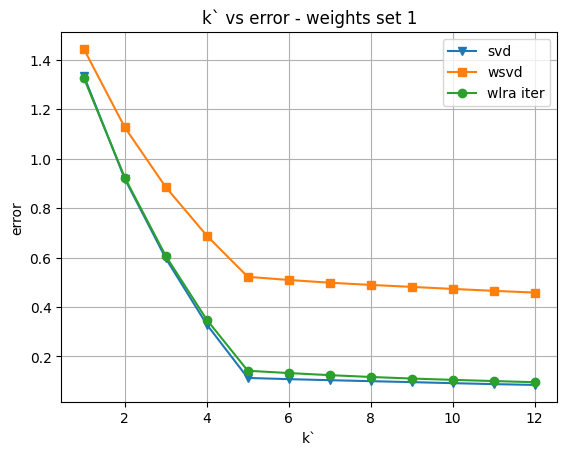

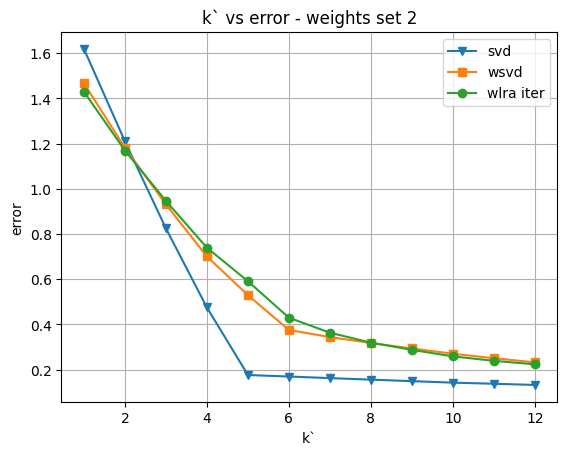

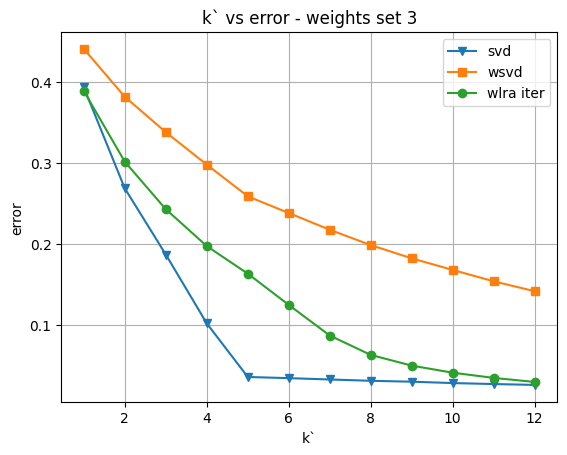

In [7]:
plt.figure()
plt.plot(ks, errors_svd_W1, 'v-', label='svd')
plt.plot(ks, errors_wsvd_W1, 's-', label='wsvd')
plt.plot(ks, errors_wlra_iter_W1, 'o-', label='wlra iter')
plt.legend()
plt.grid()
plt.xlabel('k`')
plt.ylabel('error')
plt.title('k` vs error - weights set 1')
plt.show()

plt.figure()
plt.plot(ks, errors_svd_W2, 'v-', label='svd')
plt.plot(ks, errors_wsvd_W2, 's-', label='wsvd')
plt.plot(ks, errors_wlra_iter_W2, 'o-', label='wlra iter')
plt.legend()
plt.grid()
plt.xlabel('k`')
plt.ylabel('error')
plt.title('k` vs error - weights set 2')
plt.show()

plt.figure()
plt.plot(ks, errors_svd_W3, 'v-', label='svd')
plt.plot(ks, errors_wsvd_W3, 's-', label='wsvd')
plt.plot(ks, errors_wlra_iter_W3, 'o-', label='wlra iter')
plt.legend()
plt.grid()
plt.xlabel('k`')
plt.ylabel('error')
plt.title('k` vs error - weights set 3')
plt.show()

In [8]:
# svd & wsvd

k = 2
snrs = [0.0004,0.025,0.064,0.01,0.04,0.09,0.16,0.49,1.44,4]

errors_svd_W1 = []
errors_wsvd_W1 = []
errors_wlra_iter_W1 = []

errors_svd_W2 = []
errors_wsvd_W2 = []
errors_wlra_iter_W2 = []

errors_svd_W3 = []
errors_wsvd_W3 = []
errors_wlra_iter_W3 = []

signal_power = (1/(500*500)) * np.linalg.norm(M, 'fro')**2

for snr in snrs:
  sigma = np.sqrt(signal_power/pow(10,snr/10))
  noise = np.random.normal(0, sigma, (dim,dim))
  A = M + noise

  U_svd, S_svd, Vt_svd = np.linalg.svd(A, full_matrices=False)
  U_wsvd_W1, S_wsvd_W1, Vt_wsvd_W1 = np.linalg.svd(W1*A, full_matrices=False)
  U_wsvd_W2, S_wsvd_W2, Vt_wsvd_W2 = np.linalg.svd(W2*A, full_matrices=False)
  U_wsvd_W3, S_wsvd_W3, Vt_wsvd_W3 = np.linalg.svd(W3*A, full_matrices=False)

  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W1*(A-Z_svd)**2)
  errors_svd_W1.append(error_svd)

  Z_wsvd = U_wsvd_W1[:,:k]@np.diag(S_wsvd_W1[:k])@Vt_wsvd_W1[:k,:]
  error_wsvd = np.sum(W1*(A-Z_wsvd)**2)
  errors_wsvd_W1.append(error_wsvd)

  Z_wlra_iter, err = wlra_iter(A, W1, k)
  # error_wlra_iter_W1 = np.sum(W1*(A-Z_wlra_iter)**2)
  errors_wlra_iter_W1.append(err[-1])



  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W2*(A-Z_svd)**2)
  errors_svd_W2.append(error_svd)

  Z_wsvd = U_wsvd_W2[:,:k]@np.diag(S_wsvd_W2[:k])@Vt_wsvd_W2[:k,:]
  error_wsvd = np.sum(W2*(A-Z_wsvd)**2)
  errors_wsvd_W2.append(error_wsvd)

  Z_wlra_iter, err = wlra_iter(A, W2, k)
  # error_wlra_iter_W2 = np.sum(W2*(A-Z_wlra_iter)**2)
  errors_wlra_iter_W2.append(err[-1])



  Z_svd = U_svd[:,:k]@np.diag(S_svd[:k])@Vt_svd[:k,:]
  error_svd = np.sum(W3*(A-Z_svd)**2)
  errors_svd_W3.append(error_svd)

  Z_wsvd = U_wsvd_W3[:,:k]@np.diag(S_wsvd_W3[:k])@Vt_wsvd_W3[:k,:]
  error_wsvd = np.sum(W3*(A-Z_wsvd)**2)
  errors_wsvd_W3.append(error_wsvd)

  Z_wlra_iter, err = wlra_iter(A, W3, k)
  # error_wlra_iter_W3 = np.sum(W3*(A-Z_wlra_iter)**2)
  errors_wlra_iter_W3.append(err[-1])

iter: 0 cost: 1.267805619462991
iter: 1 cost: 0.8630963880246751
iter: 0 cost: 1.4631321741421597
iter: 1 cost: 1.1714724773055742
iter: 0 cost: 0.3758120658073838
iter: 1 cost: 0.2802898462756314
iter: 0 cost: 1.2786971230063813
iter: 1 cost: 0.8641663756735407
iter: 0 cost: 1.4885437259866192
iter: 1 cost: 1.1956915249126132
iter: 0 cost: 0.37457336557906407
iter: 1 cost: 0.28149500320784243
iter: 0 cost: 1.2684025710230853
iter: 1 cost: 0.858157704413719
iter: 0 cost: 1.4717013645688333
iter: 1 cost: 1.179143037467941
iter: 0 cost: 0.37773202764854585
iter: 1 cost: 0.2984712494333583
iter: 0 cost: 1.3619010337472974
iter: 1 cost: 0.8677596360489683
iter: 0 cost: 1.4733900635117485
iter: 1 cost: 1.1836502109752831
iter: 0 cost: 0.3742375685020575
iter: 1 cost: 0.29162213863079356
iter: 0 cost: 1.275367655489343
iter: 1 cost: 0.8717341382592732
iter: 0 cost: 1.461924462137006
iter: 1 cost: 1.1747647801885117
iter: 0 cost: 0.37389986639385264
iter: 1 cost: 0.284279441225892
iter: 0 cos

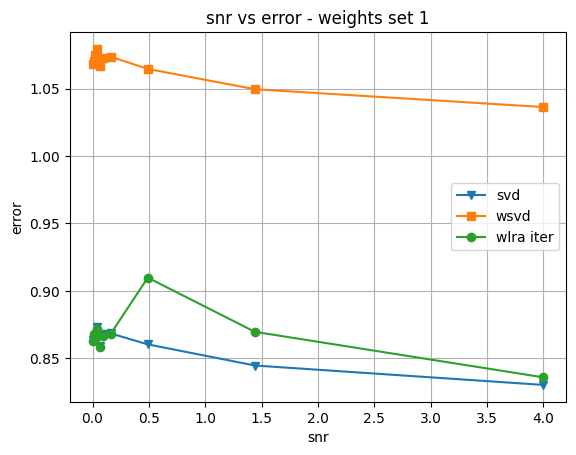

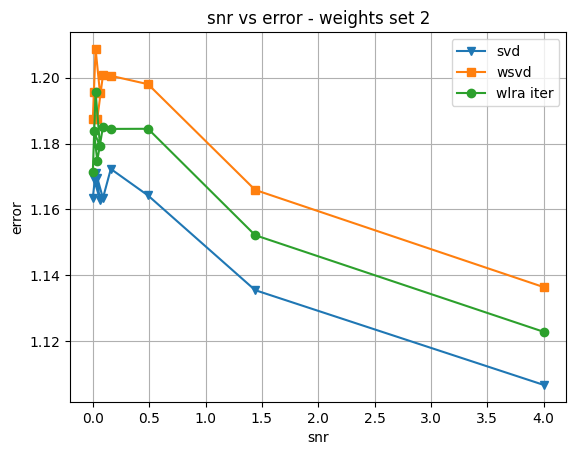

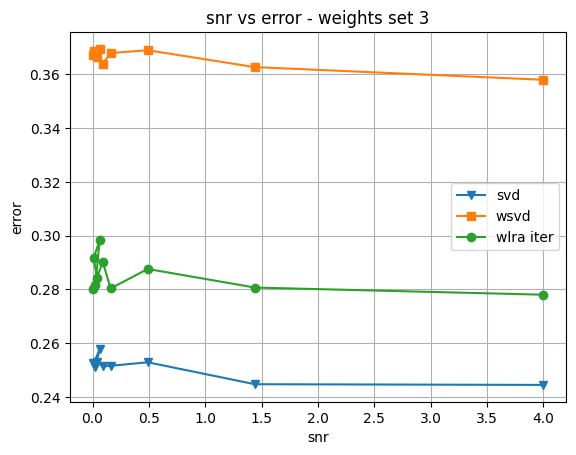

In [9]:
plt.figure()
plt.plot(snrs, errors_svd_W1, 'v-', label='svd')
plt.plot(snrs, errors_wsvd_W1, 's-', label='wsvd')
plt.plot(snrs, errors_wlra_iter_W1, 'o-', label='wlra iter')
plt.legend()
plt.grid()
plt.xlabel('snr')
plt.ylabel('error')
plt.title('snr vs error - weights set 1')
plt.show()

plt.figure()
plt.plot(snrs, errors_svd_W2, 'v-', label='svd')
plt.plot(snrs, errors_wsvd_W2, 's-', label='wsvd')
plt.plot(snrs, errors_wlra_iter_W2, 'o-', label='wlra iter')
plt.legend()
plt.grid()
plt.xlabel('snr')
plt.ylabel('error')
plt.title('snr vs error - weights set 2')
plt.show()

plt.figure()
plt.plot(snrs, errors_svd_W3, 'v-', label='svd')
plt.plot(snrs, errors_wsvd_W3, 's-', label='wsvd')
plt.plot(snrs, errors_wlra_iter_W3, 'o-', label='wlra iter')
plt.legend()
plt.grid()
plt.xlabel('snr')
plt.ylabel('error')
plt.title('snr vs error - weights set 3')
plt.show()